In [27]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

Implementar la función **create_gauss_filter(h, w, k_size, sigma)** para crear filtros gaussianos para
filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada
de Fourier.
1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una
imagen para validar el funcionamiento en el dominio espectral.

In [28]:
def create_gauss_filter(h, w, k_size, sigma):
    nucleo_g = cv.getGaussianKernel(ksize=k_size, sigma=sigma) 
    n=nucleo_g*nucleo_g. T
    z=np.zeros((h,w))
    pad_w=w//2-k_size//2
    pad_h=h//2-k_size//2
    padding=((pad_h,pad_h),(pad_w,pad_w))
    z=np.pad(n,padding,'constant', constant_values=np.zeros_like(padding))


    # Sacamos la ultima fila o columna si es par, para que queden del mismo tamaño
    if (w % 2) == 0:
        z=z[:,0:-1]
    if (h % 2) == 0:
        z=z[0:-1,:]

    return (z,np.fft.fft2(z))


In [29]:
img = cv.imread('chewbacca.jpg', cv.IMREAD_GRAYSCALE)
img.shape

(756, 1200)

Pruebo para distintos k sizes y sigmas y genero las imagenes de manera espectral 

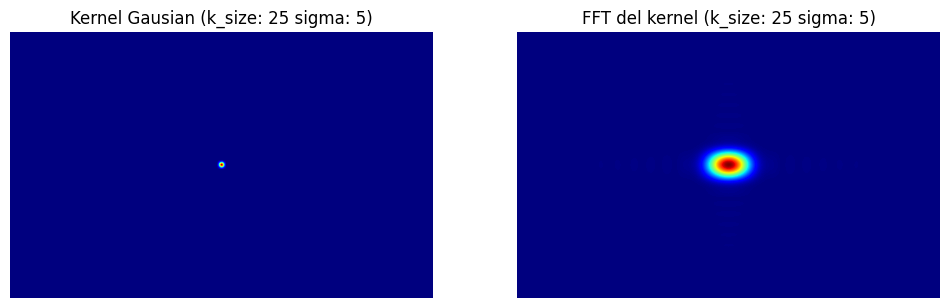

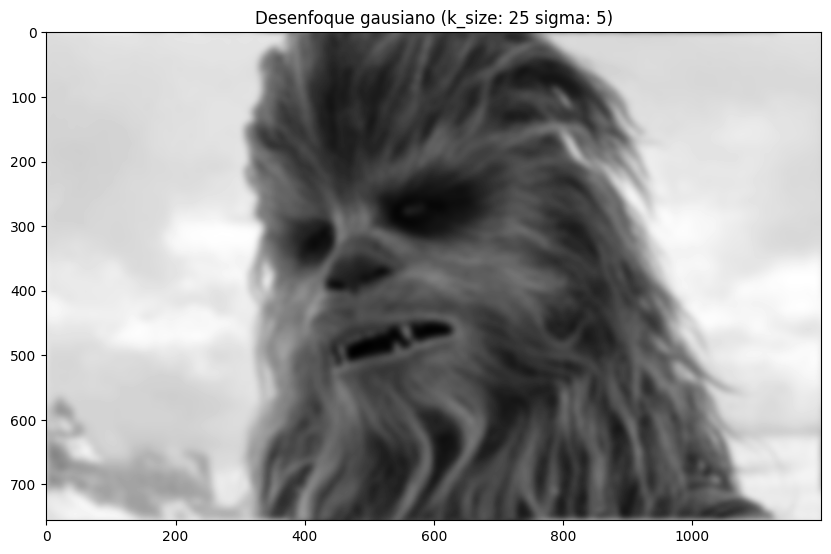

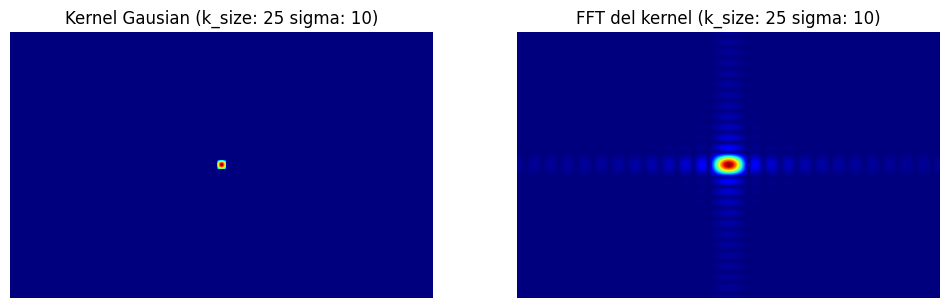

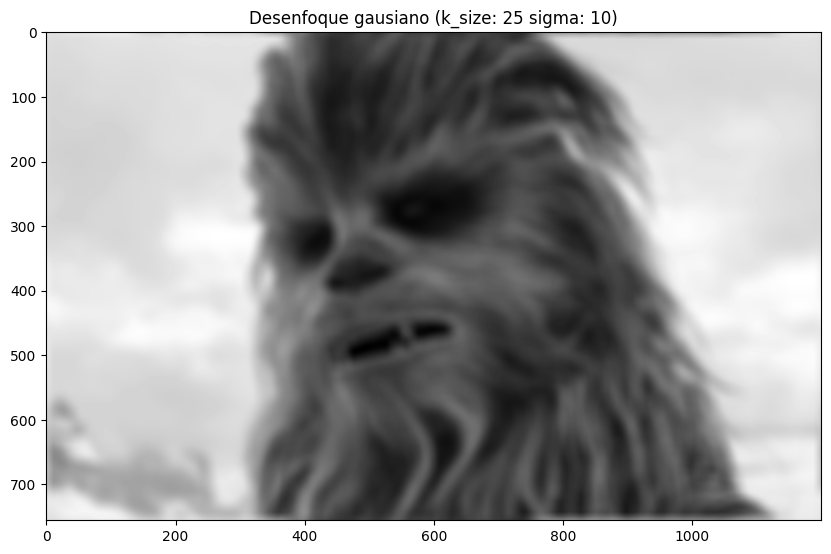

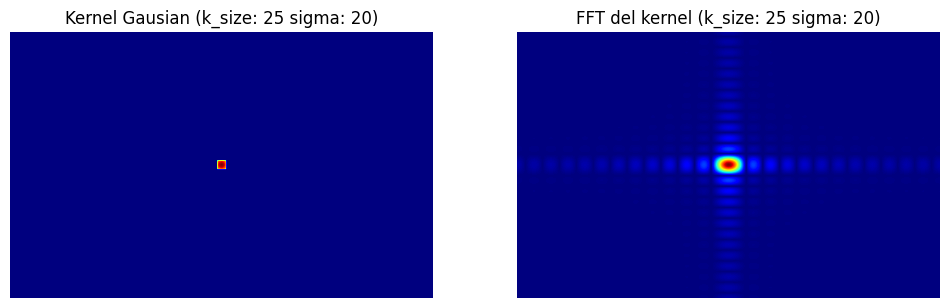

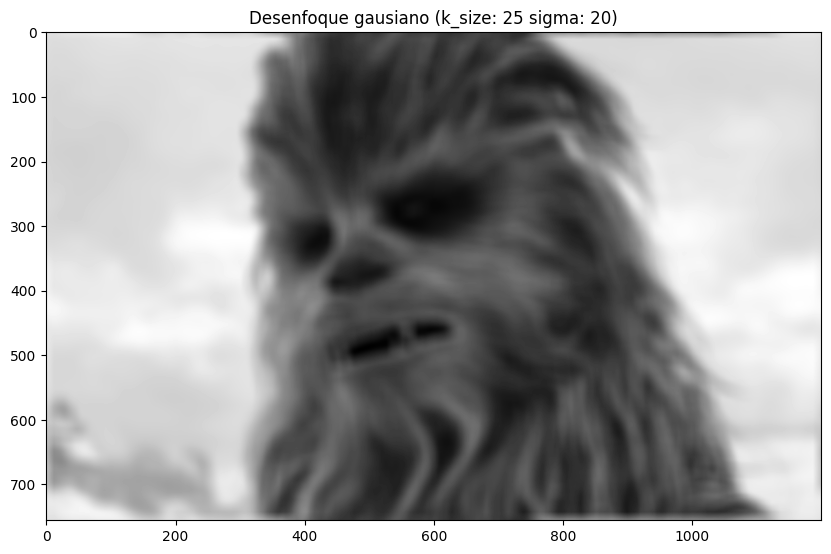

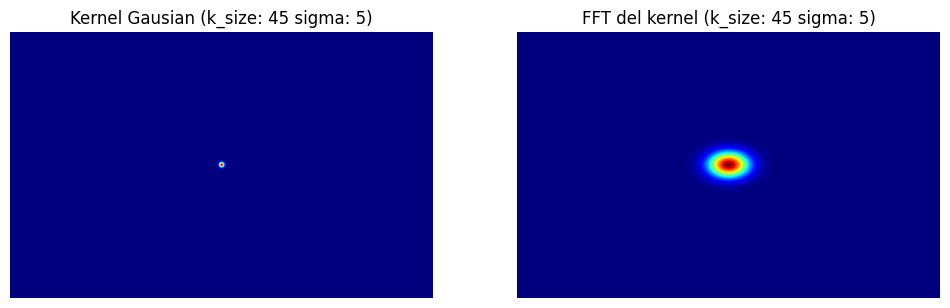

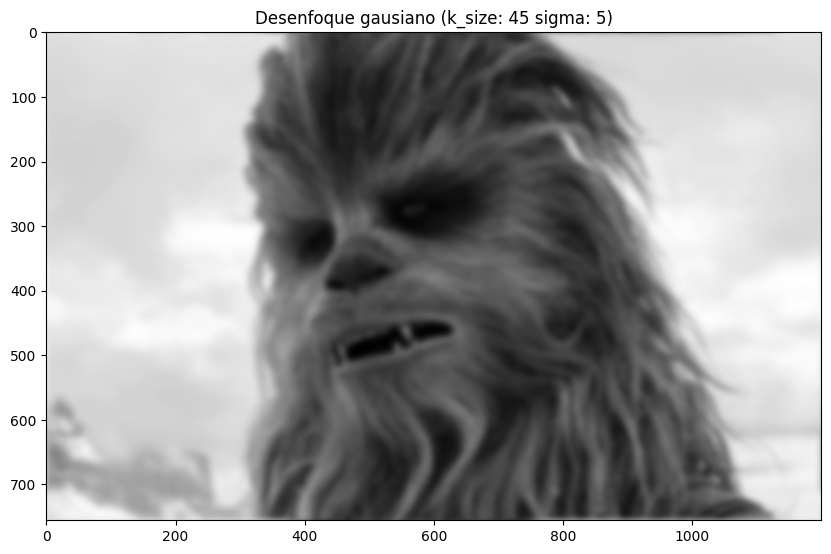

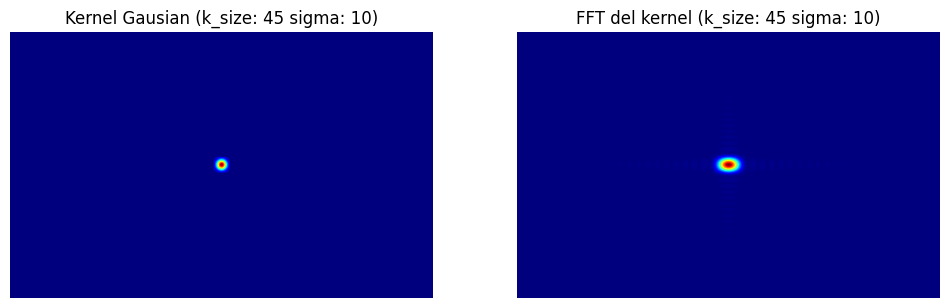

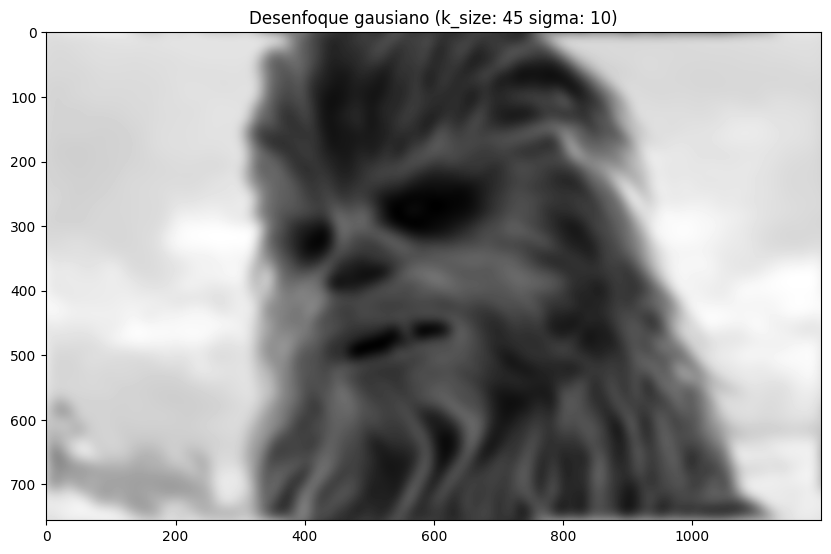

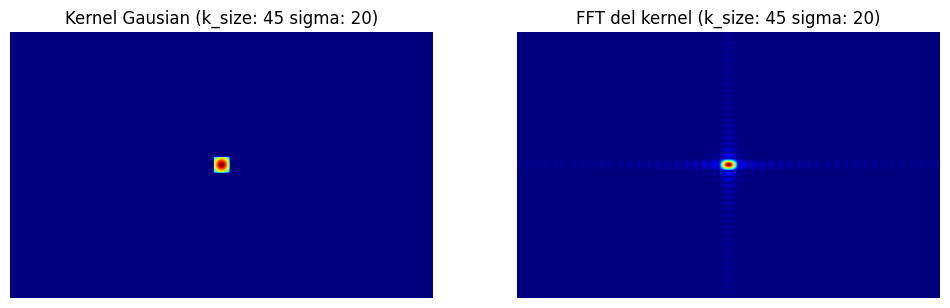

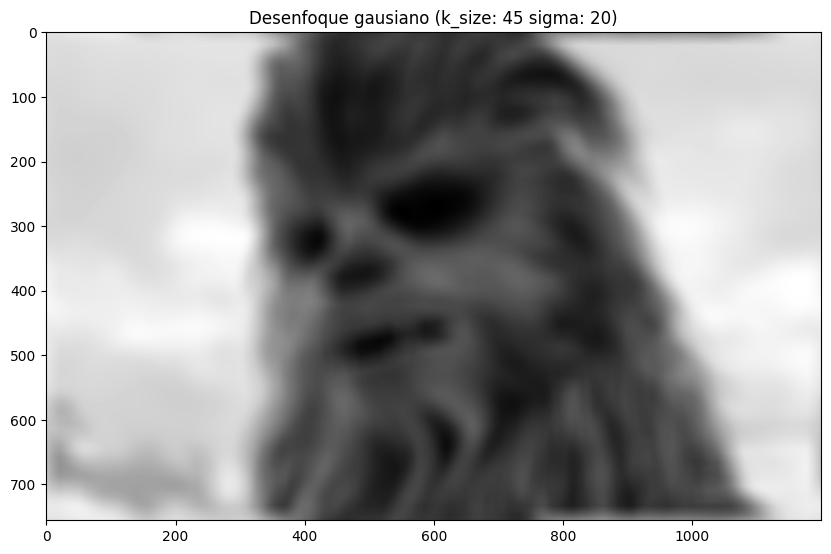

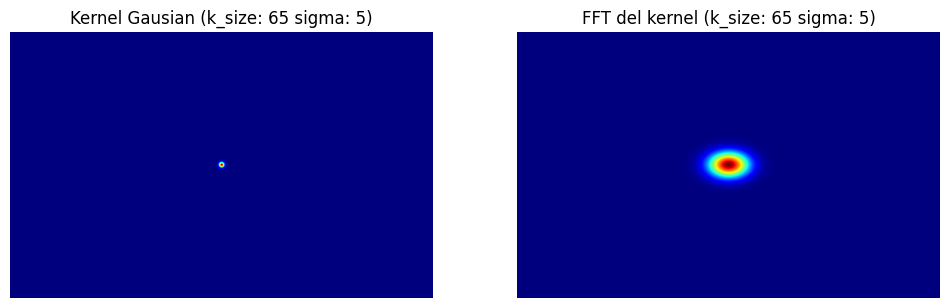

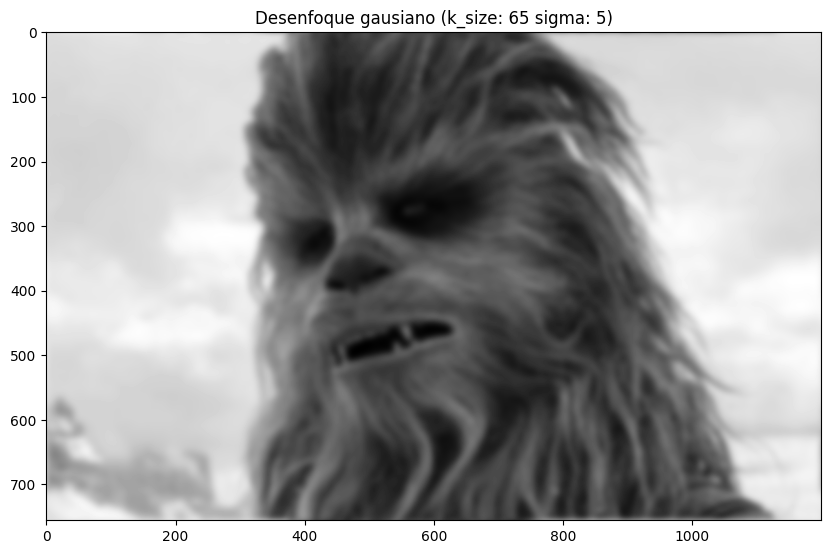

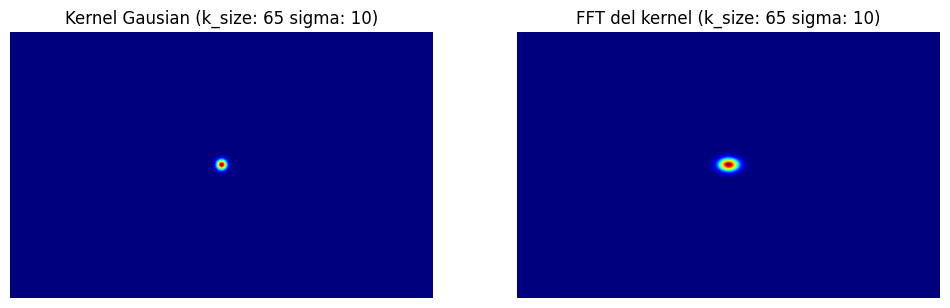

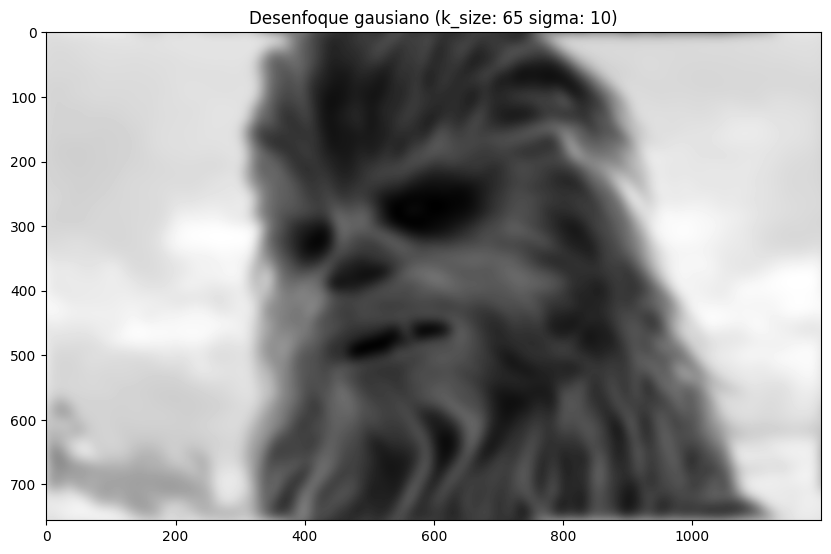

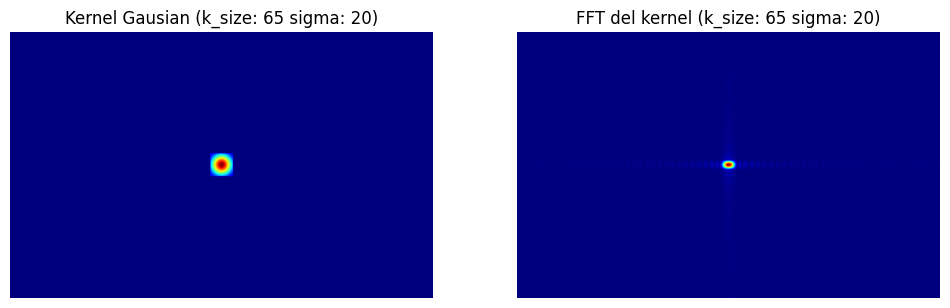

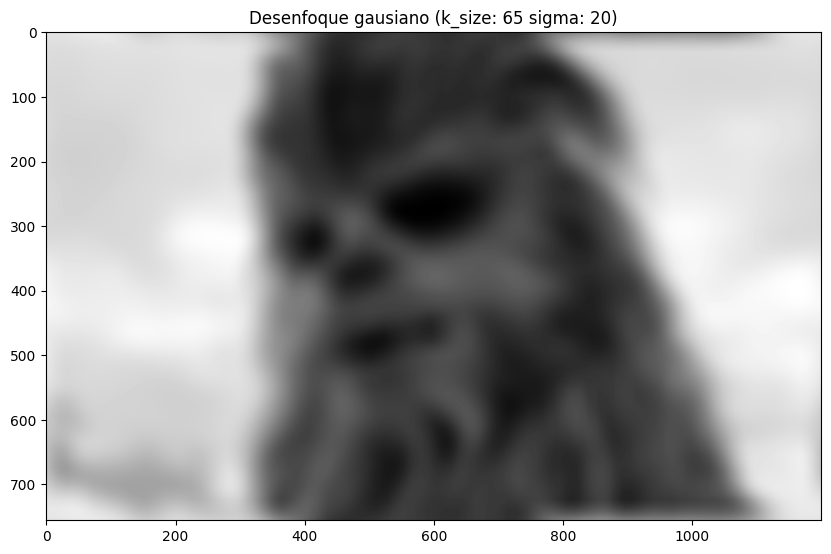

In [30]:
k_size=[25,45,65]
sigma=[5, 10, 20]


filters=[]

for k_size in k_size:
    for sig in sigma:
        kernel, kernel_tf = create_gauss_filter(h=img.shape[0], w=img.shape[1], k_size=k_size, sigma=sig)
        plt.figure(figsize=(12,12))
        plt.subplot(1,2,1)
        plt.axis('off')
        plt.title(f"Kernel Gausian (k_size: {k_size} sigma: {sig})")
        plt.imshow(kernel, cmap='jet')
        plt.subplot(1,2,2)
        plt.axis('off')
        plt.title(f"FFT del kernel (k_size: {k_size} sigma: {sig})")
        tf_shifted = np.fft.fftshift(kernel_tf)
        plt.imshow(np.abs(tf_shifted), cmap='jet')

        img_fft = np.fft.fft2(img)
        filtered = img_fft * kernel_tf

        img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

        plt.figure(figsize=(10,10))
        plt.imshow(img_gauss, cmap='gray')
        plt.title(f'Desenfoque gausiano (k_size: {k_size} sigma: {sig})')

        img_gauss_c = cv.GaussianBlur(img, ksize=(k_size,k_size), sigmaX=sig,  sigmaY=sig)

        filters.append([sig,k_size,kernel,kernel_tf,img_gauss,img_gauss_c])

2. Usando el método descripto en el paper “Image Sharpness Measure for Blurred Images in Frequency
Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.

In [31]:
def method1(img):
    #Step 1: Compute F which is the Fourier Transform representation of image I
    img_fft = np.fft.fft2(img)
    #Step 2: Find Fc which is obtained by shifting the origin of F to centre.
    tf_shifted = np.fft.fftshift(img_fft)
    #Step 3: Calculate AF = abs (Fc) where AF is the absolute value of the centered Fourier transform of image I.
    tf_shifted_abs =np.abs(tf_shifted)
    #Step 4: Calculate M = max (AF) where M is the maximum value of the frequency component in F.
    M = np.max(tf_shifted_abs)
    #Step 5: Calculate T H = the total number of pixels in F whose pixel value > thres, where thres = M/1000.
    thres=M/1000
    out=np.array([1 if i>thres else 0 for i in tf_shifted_abs.flatten()])
    #Step 6: Calculate Image Quality measure (FM) from equation (1)
    return np.sum(out)/(img.shape[0]*img.shape[1])

Aplico para filtrado por convolución y espectral

Metrica del método descripto en el paper Image Sharpness Measure for Blurred Images in Frequency Domain para filtrado por convolución: 0.001462742504409171


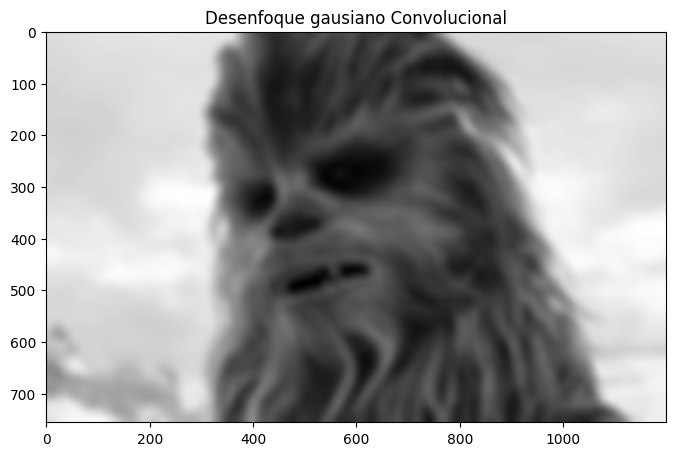

In [32]:
#Convolucional

#Hiper parametros
k_size=31
sigma=10

kernel, kernel_tf = create_gauss_filter(h=img.shape[0], w=img.shape[1], k_size=k_size, sigma=sigma)
tf_shifted = np.fft.fftshift(kernel_tf)
img_fft = np.fft.fft2(img)
filtered = img_fft * kernel_tf
img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

img_gauss = cv.GaussianBlur(img, ksize=(k_size,k_size), sigmaX=sigma,  sigmaY=sigma)
plt.figure(figsize=(8,8))
plt.imshow(img_gauss, cmap='gray')
plt.title('Desenfoque gausiano Convolucional')

print("Metrica del método descripto en el paper Image Sharpness Measure for Blurred Images in Frequency Domain para filtrado por convolución:", method1(img_gauss))

Metrica del método descripto en el paper Image Sharpness Measure for Blurred Images in Frequency Domain para filtrado espectral: 0.0011959876543209877


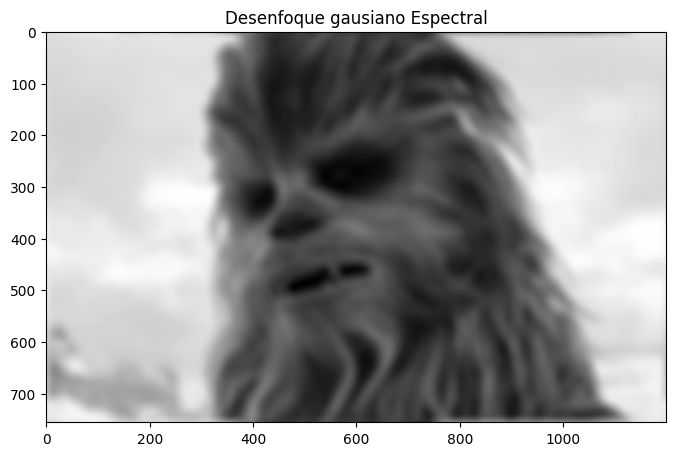

In [33]:
#Espectral

img_fft = np.fft.fft2(img)
filtered = img_fft * kernel_tf

img_gauss_e = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

plt.figure(figsize=(8,8))
plt.imshow(img_gauss_e, cmap='gray')
plt.title('Desenfoque gausiano Espectral')

print("Metrica del método descripto en el paper Image Sharpness Measure for Blurred Images in Frequency Domain para filtrado espectral:", method1(img_gauss_e))

Repito para distintios Sigmas y k sizes

In [34]:
print("Pruebo la métrica para los distintos Sigmas y K Sizes")

m1_e=[]
m1_c=[]

for i in filters:
    #[sig,k_size,kernel,kernel_tf,img_gauss,img_gauss_c]
    print("Sigma:",i[0]," | ","k_size:",i[1])
    print("Metrica:", method1(i[4]))
    m1_e.append(method1(i[4]))
    m1_c.append(method1(i[5]))
    

Pruebo la métrica para los distintos Sigmas y K Sizes
Sigma: 5  |  k_size: 25
Metrica: 0.0018176807760141094
Sigma: 10  |  k_size: 25
Metrica: 0.0013569223985890652
Sigma: 20  |  k_size: 25
Metrica: 0.0012555114638447972
Sigma: 5  |  k_size: 45
Metrica: 0.0017779982363315696
Sigma: 10  |  k_size: 45
Metrica: 0.0010174162257495592
Sigma: 20  |  k_size: 45
Metrica: 0.0007220017636684304
Sigma: 5  |  k_size: 65
Metrica: 0.0017779982363315696
Sigma: 10  |  k_size: 65
Metrica: 0.0009490740740740741
Sigma: 20  |  k_size: 65
Metrica: 0.0005324074074074074


Grafico la metrica en función del k size, sigma y espectral vs convolucional

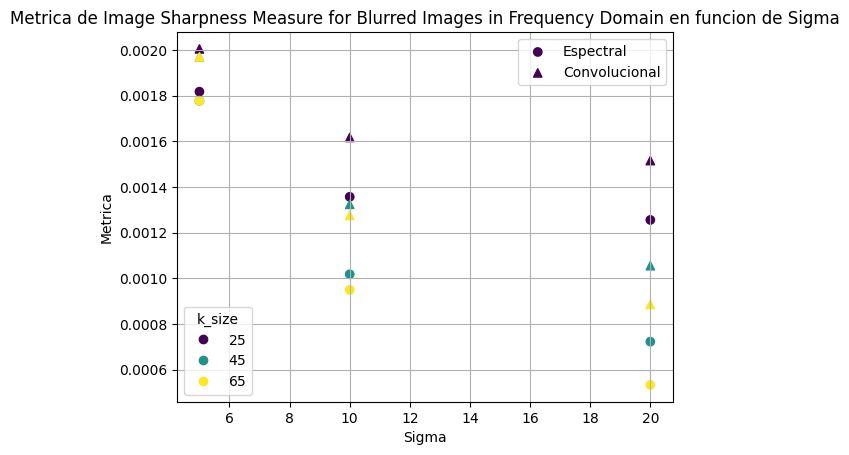

In [35]:
fig, ax = plt.subplots()
a=ax.scatter([i[0] for i in filters],m1_e,c=[i[1] for i in filters],marker='o',label="Espectral")
b=ax.scatter([i[0] for i in filters],m1_c,c=[i[1] for i in filters],marker='^',label="Convolucional")


legend1 = ax.legend(*a.legend_elements(),
                   loc="lower left", title="k_size")
ax.add_artist(legend1)

ax.legend(handles=[a,b])


ax.set(xlabel='Sigma', ylabel='Metrica',
       title='Metrica de Image Sharpness Measure for Blurred Images in Frequency Domain en funcion de Sigma')

ax.grid()

plt.show()

3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of focus measure operators in shape-from-focus”

Utilizo la siguiente metrica:

### Gray-level variance (STA3)

\begin{equation}
\phi_{x,y} =\sum_{(i,j) \in \Omega(x,y)} (I(i,j) - \mu)   ^2
\end{equation}

Aplico la metrica para la misma imagen que el punto anterior, tanto para convolucional y espectral

In [36]:
## Gray-level variance (STA3)
def STA3(img):
    mu=np.mean(img)
    return np.sum(np.frompyfunc(lambda x: (x-mu)**2, 1, 1)(img))


print("Metrica Gray-level variance (STA3) para imagén sin filtro: ")
print(STA3(img))

print("Metrica Gray-level variance (STA3) para imagén con filtro con convolución: ")
print(STA3(img_gauss))

print("Metrica Gray-level variance (STA3) para imagén con filtro espectral: ")
print(STA3(img_gauss_e))

Metrica Gray-level variance (STA3) para imagén sin filtro: 
5434149420.091484
Metrica Gray-level variance (STA3) para imagén con filtro con convolución: 
5190098219.695296
Metrica Gray-level variance (STA3) para imagén con filtro espectral: 
5143392472.61049


Repito para distintos valores de k size y sigma

In [37]:
print("Pruebo la métrica para los distintos Sigmas y K Sizes")

STA3_out_e=[]
STA3_out_c=[]
for i in filters:
    #[sig,k_size,kernel,kernel_tf,img_gauss,img_gauss_c]
    print("Sigma:",i[0]," | ","k_size:",i[1])
    print("Metrica para convolucional:", STA3(i[4]))
    print("Metrica para espectral:", STA3(i[5]))
    STA3_out_e.append(STA3(i[4]))
    STA3_out_c.append(STA3(i[5]))

Pruebo la métrica para los distintos Sigmas y K Sizes
Sigma: 5  |  k_size: 25
Metrica para convolucional: 5235680355.442063
Metrica para espectral: 5266258630.851431
Sigma: 10  |  k_size: 25
Metrica para convolucional: 5176952617.2689085
Metrica para espectral: 5217760467.706864
Sigma: 20  |  k_size: 25
Metrica para convolucional: 5159697564.879932
Metrica para espectral: 5203366258.257578
Sigma: 5  |  k_size: 45
Metrica para convolucional: 5229334105.077758
Metrica para espectral: 5260600385.512337
Sigma: 10  |  k_size: 45
Metrica para convolucional: 5097291880.50592
Metrica para espectral: 5151747673.272365
Sigma: 20  |  k_size: 45
Metrica para convolucional: 5020041345.61442
Metrica para espectral: 5087607702.468231
Sigma: 5  |  k_size: 65
Metrica para convolucional: 5229327288.2564
Metrica para espectral: 5260600385.512337
Sigma: 10  |  k_size: 65
Metrica para convolucional: 5080187421.416095
Metrica para espectral: 5137640360.538074
Sigma: 20  |  k_size: 65
Metrica para convolucio

Grafico la metrica en función del k size, sigma y espectral vs convolucional

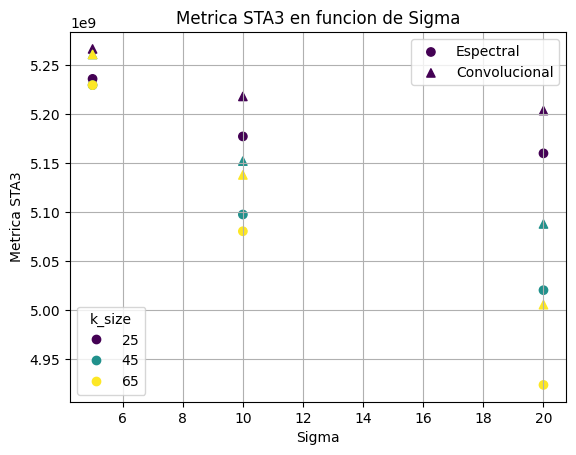

In [38]:
fig, ax = plt.subplots()
a=ax.scatter([i[0] for i in filters],STA3_out_e,c=[i[1] for i in filters],marker='o',label="Espectral")
b=ax.scatter([i[0] for i in filters],STA3_out_c,c=[i[1] for i in filters],marker='^',label="Convolucional")


legend1 = ax.legend(*a.legend_elements(),
                   loc="lower left", title="k_size")
ax.add_artist(legend1)

ax.legend(handles=[a,b])


ax.set(xlabel='Sigma', ylabel='Metrica STA3',
       title='Metrica STA3 en funcion de Sigma')

ax.grid()

plt.show()

Se nota que la metrica da menor, para los filtros gaussianos. Creo que tiene sentido dado a es un filtro que suaviza y de alguna manera promedia los valores para estar mas cerca de la media.

Así mismo, a medida que los valores de sigma son mayores se nota una divergencia entre el metodo espectral y convolucional.